In [16]:
# define logging and working directory
# ------------------------------------------
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()
# jupyter magic config
# ------------------------------------------
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# this should import glob, os, and many other standard libs
# ------------------------------------------ 
from src.utils.Notebook_imports import *
# local imports
# ------------------------------------------ 
from src.utils.Utils_io import Console_and_file_logger, init_config
# import external libs
# ------------------------------------------ 
import pandas as pd
import numpy as np
from ipyfilechooser import FileChooser
import glob
import os


search for root_dir and set working directory
Working directory set to: /mnt/ssd/git/dynamic-cmr-models


In [17]:
def evaluate(exp_root, result_df='results.xlsx', pred_suffix = 'pred'):
    global all_pred_files
    print('eval: {}'.format(exp_root))
    from src.utils.Metrics import meandiff
    phases = ['ED', 'MS', 'ES', 'PF', 'MD']
    
    direct_path = '{}/{}/*.npy'.format(exp_root, pred_suffix)
    print('path to predictions: {}'.format(direct_path))
    all_pred_files = glob.glob(direct_path)
    if len(all_pred_files) == 0:    
        all_pred_files = sorted(glob.glob('{}/**/**/{}/*.npy'.format(exp_root, pred_suffix), recursive=False))
    """if len(all_pred_files) == 0:
        all_pred_files = sorted(glob.glob('{}/{}/*.npy'.format(exp_root, pred_suffix), recursive=False))"""
    #assert len(all_pred_files) ==4, 'we expect a four-fold cv, but found: {} predictions'.format(len(all_pred_files))
    print('predictions found: {}'.format(len(all_pred_files)))
    
    # Load the numpy files
    preds = list(map(lambda x : np.load(x), all_pred_files))
    # stack the numpy files
    preds = np.concatenate(preds, axis=1)
    
    # calculate the mean differences
    res = meandiff(preds[0], preds[1], apply_sum=False, apply_average=False)
    df = pd.DataFrame(res.numpy(), columns=phases)
    df.to_excel(os.path.join(exp_root, result_df))
    return df

# Evaluate one experiment

In [18]:
# choose an experiment folder
sds_storage = '/mnt/sds/sd20i001/sven/code/dynamic-cmr-models/exp/phasereg_v3/'
local_storage = os.path.join(os.getcwd(),'exp/local')
fchooser = FileChooser(sds_storage, '')
display(fchooser)
@interact
def eval_interact(evaluate_=False):
    global df
    if evaluate_: 
        df = evaluate(fchooser.selected, pred_suffix='pred')

FileChooser(path='/mnt/sds/sd20i001/sven/code/dynamic-cmr-models/exp/phasereg_v3', filename='', title='HTML(va…

interactive(children=(Checkbox(value=False, description='evaluate_'), Output()), _dom_classes=('widget-interac…

# Evaluate multiple experiments - create a results.xlsx with one row per patient

In [6]:
experiments = sorted(glob.glob(os.path.join(sds_storage,'*/')))
print('Evaluate: {} experiments'.format(len(experiments)))
excl = 'tres'
results = []
results_names = []
for e in experiments:
    try:
        if excl not in e:
            results.append(evaluate(e))
            results_names.append(e.split('/')[-2])
        else:
            print('skip by substring: {}'.format(excl))
    except Exception as ex:
        print('Faild at: {} with: {}'.format(e,ex))

Evaluate: 12 experiments
eval: /mnt/sds/sd20i001/sven/code/dynamic-cmr-models/exp/phasereg_v3/24_8_128_128_flow_conv/
path to predictions: /mnt/sds/sd20i001/sven/code/dynamic-cmr-models/exp/phasereg_v3/24_8_128_128_flow_conv//pred/*.npy
predictions found: 0
Faild at: /mnt/sds/sd20i001/sven/code/dynamic-cmr-models/exp/phasereg_v3/24_8_128_128_flow_conv/ with: need at least one array to concatenate
eval: /mnt/sds/sd20i001/sven/code/dynamic-cmr-models/exp/phasereg_v3/24_8_128_128_flow_conv_bilstm64/
path to predictions: /mnt/sds/sd20i001/sven/code/dynamic-cmr-models/exp/phasereg_v3/24_8_128_128_flow_conv_bilstm64//pred/*.npy
predictions found: 4
Instructions for updating:
Use fn_output_signature instead
eval: /mnt/sds/sd20i001/sven/code/dynamic-cmr-models/exp/phasereg_v3/24_8_128_128_flow_conv_bilstm64_noROT/
path to predictions: /mnt/sds/sd20i001/sven/code/dynamic-cmr-models/exp/phasereg_v3/24_8_128_128_flow_conv_bilstm64_noROT//pred/*.npy
predictions found: 4
eval: /mnt/sds/sd20i001/sve

# Build one dataframe with one row per experiment

# Error per Phase as df

In [7]:
# helper, aggregate one experiment
def aggregate_df(df):
    cols = ['Mean/phase', 'SD/phase']
    temp = pd.DataFrame(columns=cols)
    temp[cols[0]] = df.mean(axis=0)
    temp[cols[1]] = df.std(axis=0)
    temp = temp.round(3)
    temp = temp.stack()
    temp['overall','Mean'] = df.values.mean()
    temp['overall','SD'] = df.values.std()
    temp['Cycle','Mean'] = np.mean(df.sum(axis=1))
    temp['Cycle','SD'] = np.std(df.sum(axis=1))
    return temp

In [8]:
results_agg = [aggregate_df(elem) for elem in results]
results_agg_df = pd.concat(results_agg, axis=1).T
results_agg_df.index = results_names

# Show the aggregated results per experiment

In [15]:
# highlight the lowest values
results_agg_df.style.highlight_min(color = 'lightgreen', axis = 0)

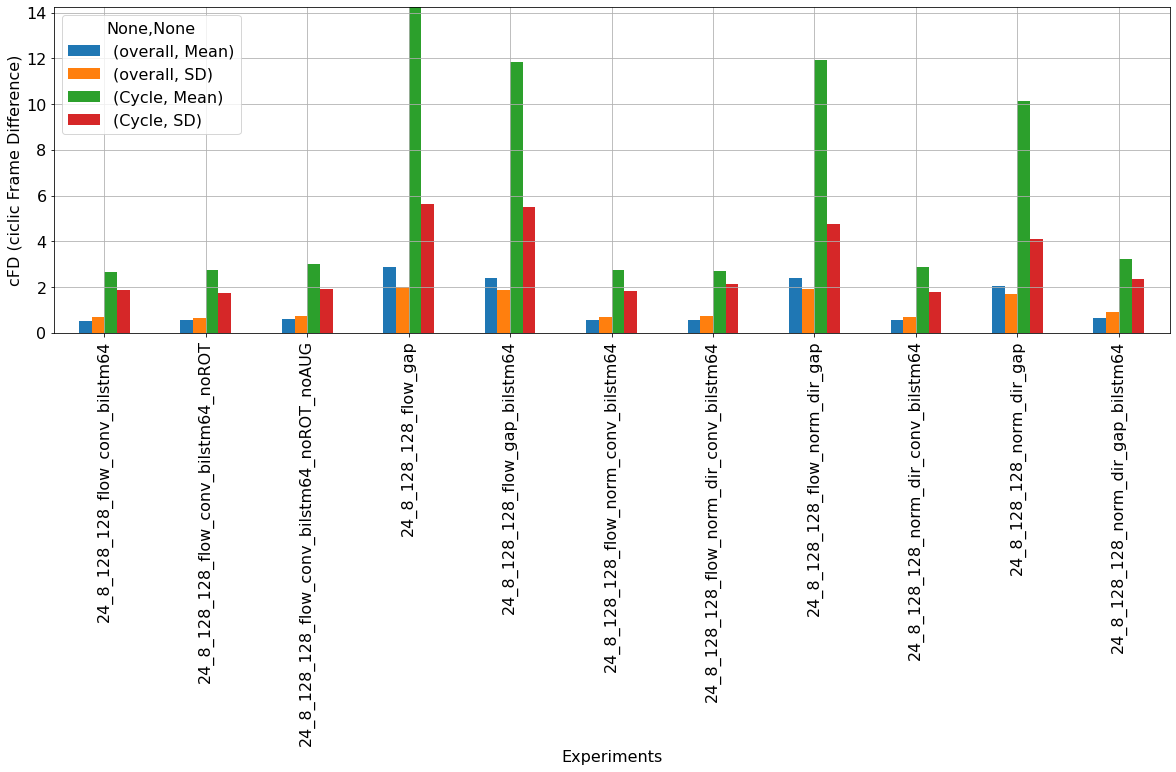

In [14]:
# create a barplot for all experiments overall (mean/sd)
f = plt.figure(figsize=(20,6))
plt.rcParams['font.size'] = '16'
ax = f.gca()
ax.set_ylim(bottom=0, top=results_agg_df['Cycle']['Mean'].max())
ax.set_ylabel('cFD (ciclic Frame Difference)')
ax.set_xlabel('Experiments')
results_agg_df[['overall','Cycle']].plot(kind='bar',ax=ax, grid=True)
plt.show()

# Error per phase, overall and per cardiac cycle

In [27]:
print('Mean per phase: \n{}'.format(df.mean(axis=0)))
print('Median per phase: \n{}'.format(df.median(axis=0)))
print('Std per phase: \n{}'.format(df.std(axis=0)))

print('Mean cFD: \n{:10.4f}'.format(df.values.mean()))
#print('Median overall: \n{:10.4f}'.format(np.median(df.values)))
print('Std mean cFD: \n{:10.4f}'.format(df.values.std()))

print('per cycle cFD: \n{:10.4f}'.format(np.mean(df.sum(axis=1))))
print('per cycle cFD std: \n{:10.4f}'.format(np.std(df.sum(axis=1))))

Mean per phase: 
ED    0.507194
MS    0.456835
ES    0.449640
PF    0.449640
MD    0.780576
dtype: float32
Median per phase: 
ED    0.0
MS    0.0
ES    0.0
PF    0.0
MD    1.0
dtype: float32
Std per phase: 
ED    0.561990
MS    0.585573
ES    0.643756
PF    0.609181
MD    0.882266
dtype: float32
Mean cFD: 
    0.5288
Std mean cFD: 
    0.6777
per cycle cFD: 
    2.6439
per cycle cFD std: 
    1.8503


# Violin plot - error per phase

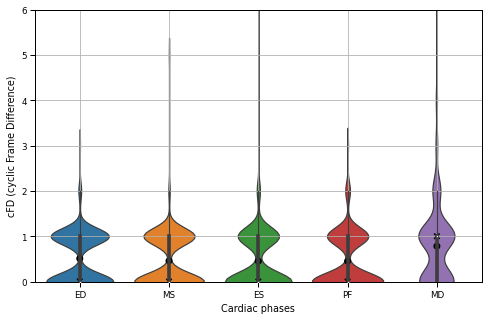

In [24]:
import seaborn as sb
sb.set_context('paper')
f = plt.figure(figsize=(8,5))
plt.rcParams['font.size'] = '16'
ax = f.gca()
ax.set_ylim(bottom=0, top=6)
ax.set_ylabel('cFD (cyclic Frame Difference)')
ax.set_xlabel('Cardiac phases')
#_ = DF_METADATA[phases].plot(kind='violin'),
sb.violinplot(data=df, orient='v', ax = ax)
sb.pointplot(data=df, orient='v', ax = ax, estimator=np.mean,color="black", markers="o", ci=None,join=False)
sb.pointplot(data=df, orient='v', ax = ax, estimator=np.median,color="black", markers="x", size=2, ci=None,join=False)
plt.grid()
plt.savefig('bestphase')


# Error per cardiac cycle

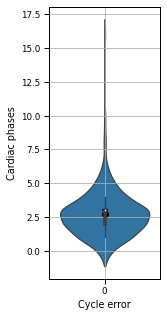

In [29]:
import seaborn as sb
sb.set_context('paper')
f = plt.figure(figsize=(2,5))
ax = f.gca()
ax.set_ylabel('Cardiac phases')
ax.set_xlabel('Cycle error')
temp = df.sum(axis=1)
sb.violinplot(data=temp, orient='v', ax = ax)
#sb.scatterplot(data=temp, ax=ax)
sb.pointplot(data=temp, orient='v', ax = ax, estimator=np.mean,color="black", markers="o", ci=None,join=False)
sb.pointplot(data=temp, orient='v', ax = ax, estimator=np.median,color="black", markers="_", ci=None,join=False)
plt.grid()
plt.show()